In [1]:
import torch as torch
import torchvision as tv
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as image
from torch.utils.data import DataLoader
import numpy as np
import os
import os.path
from torch import nn
from pdb import set_trace
from utils import show_images, show_outputs, Downsample, Noise, SSIM
from dataset import MNISTsuperimposed
from models import UpsamplingTransformer

In [2]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     Downsample(),
     Noise(mean=0, dev=0.1)
     ])
target_transform= transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor()
     ])
train_superimposed = MNISTsuperimposed("./MNIST data/train", train = True, download = True, transform = transform, target_transform=target_transform)
test_supserimposed = MNISTsuperimposed("./MNIST data/train", train = False, download = True, transform = transform, target_transform=target_transform)

In [3]:
trainset = DataLoader(train_superimposed, batch_size=64, shuffle=True)

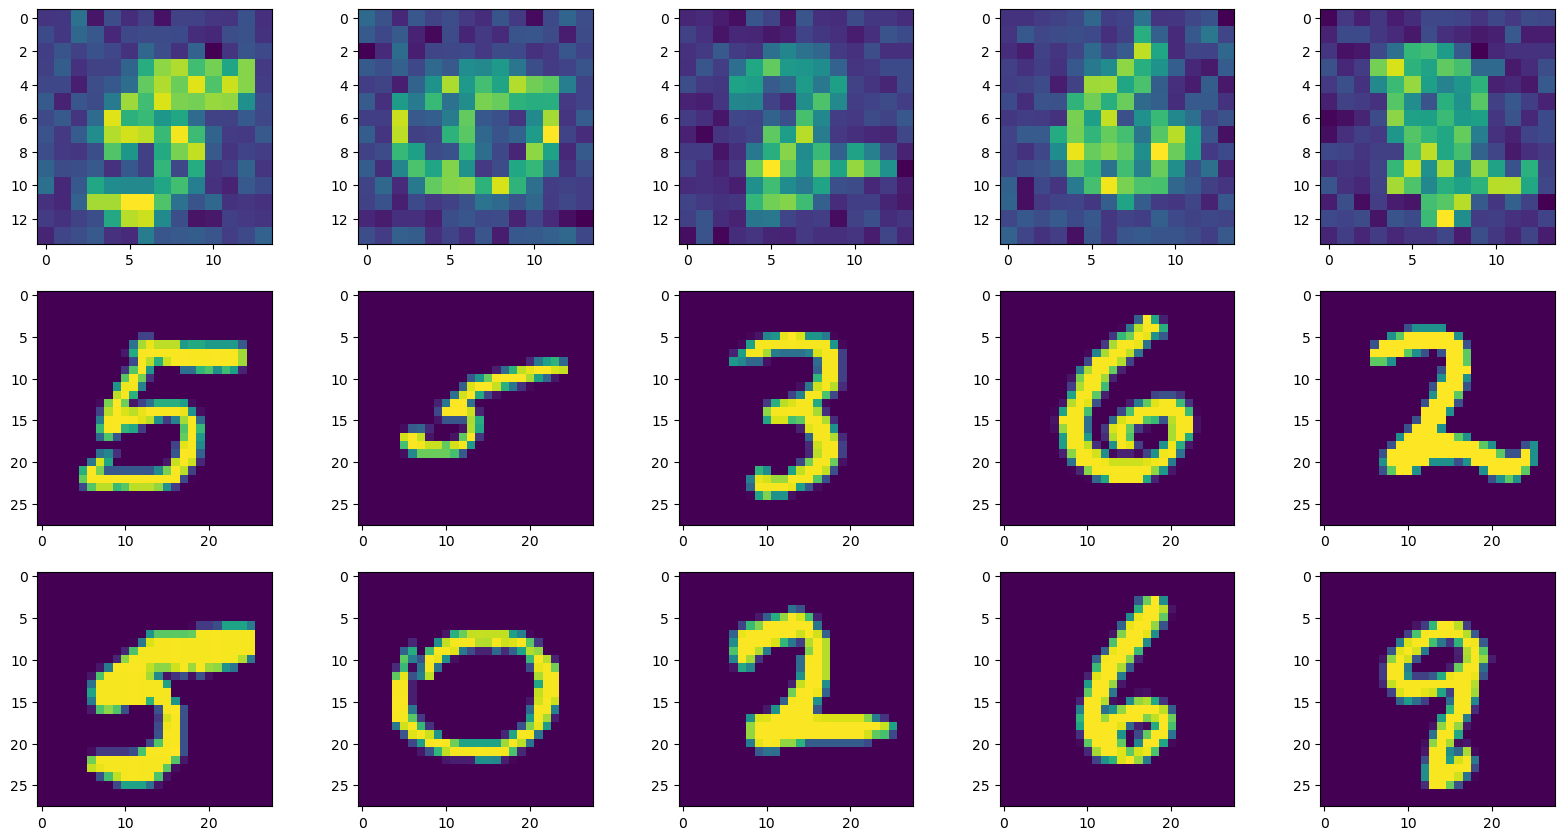

In [4]:
inputs, outputs = next(iter(trainset))
show_images(inputs, outputs)

In [8]:
model = UpsamplingTransformer(
    d_model=288,
    encoder_feedforward=512,
    decoder_feedforward=512,
    encoder_heads=144,
    decoder_heads=144,
    num_decoder_layers=1,
    num_encoder_layers=1,
    upscale=1
).cuda()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
Huber = nn.HuberLoss()
ssim = SSIM()
print('Number of model parameter: '+str(sum([parameter.numel() for parameter in model.parameters()])))

Number of model parameter: 1711017


In [6]:
epochs = 100
train_loss = []
flag = True
for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(trainset):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = Huber(targets.to(device), outputs.to(device))
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if i % 100 == 99:
            print('[%d, %5d] loss batch : %.6f' %
                  (epoch + 1, i + 1, loss.item()))
        
print('Finished Training')
flag = False

[1,   100] loss batch : 0.075967
[1,   200] loss batch : 0.067095
[1,   300] loss batch : 0.060545
[1,   400] loss batch : 0.056219
[1,   500] loss batch : 0.051321
[1,   600] loss batch : 0.046988
[1,   700] loss batch : 0.043529
[1,   800] loss batch : 0.040861
[1,   900] loss batch : 0.039287
[2,   100] loss batch : 0.035635
[2,   200] loss batch : 0.034738
[2,   300] loss batch : 0.033050
[2,   400] loss batch : 0.032683
[2,   500] loss batch : 0.031955
[2,   600] loss batch : 0.029930
[2,   700] loss batch : 0.028673
[2,   800] loss batch : 0.028037
[2,   900] loss batch : 0.028123
[3,   100] loss batch : 0.026460
[3,   200] loss batch : 0.025698
[3,   300] loss batch : 0.025833
[3,   400] loss batch : 0.026022
[3,   500] loss batch : 0.024911
[3,   600] loss batch : 0.025545
[3,   700] loss batch : 0.023666
[3,   800] loss batch : 0.024508
[3,   900] loss batch : 0.023743
[4,   100] loss batch : 0.023931
[4,   200] loss batch : 0.023360
[4,   300] loss batch : 0.023190
[4,   400]

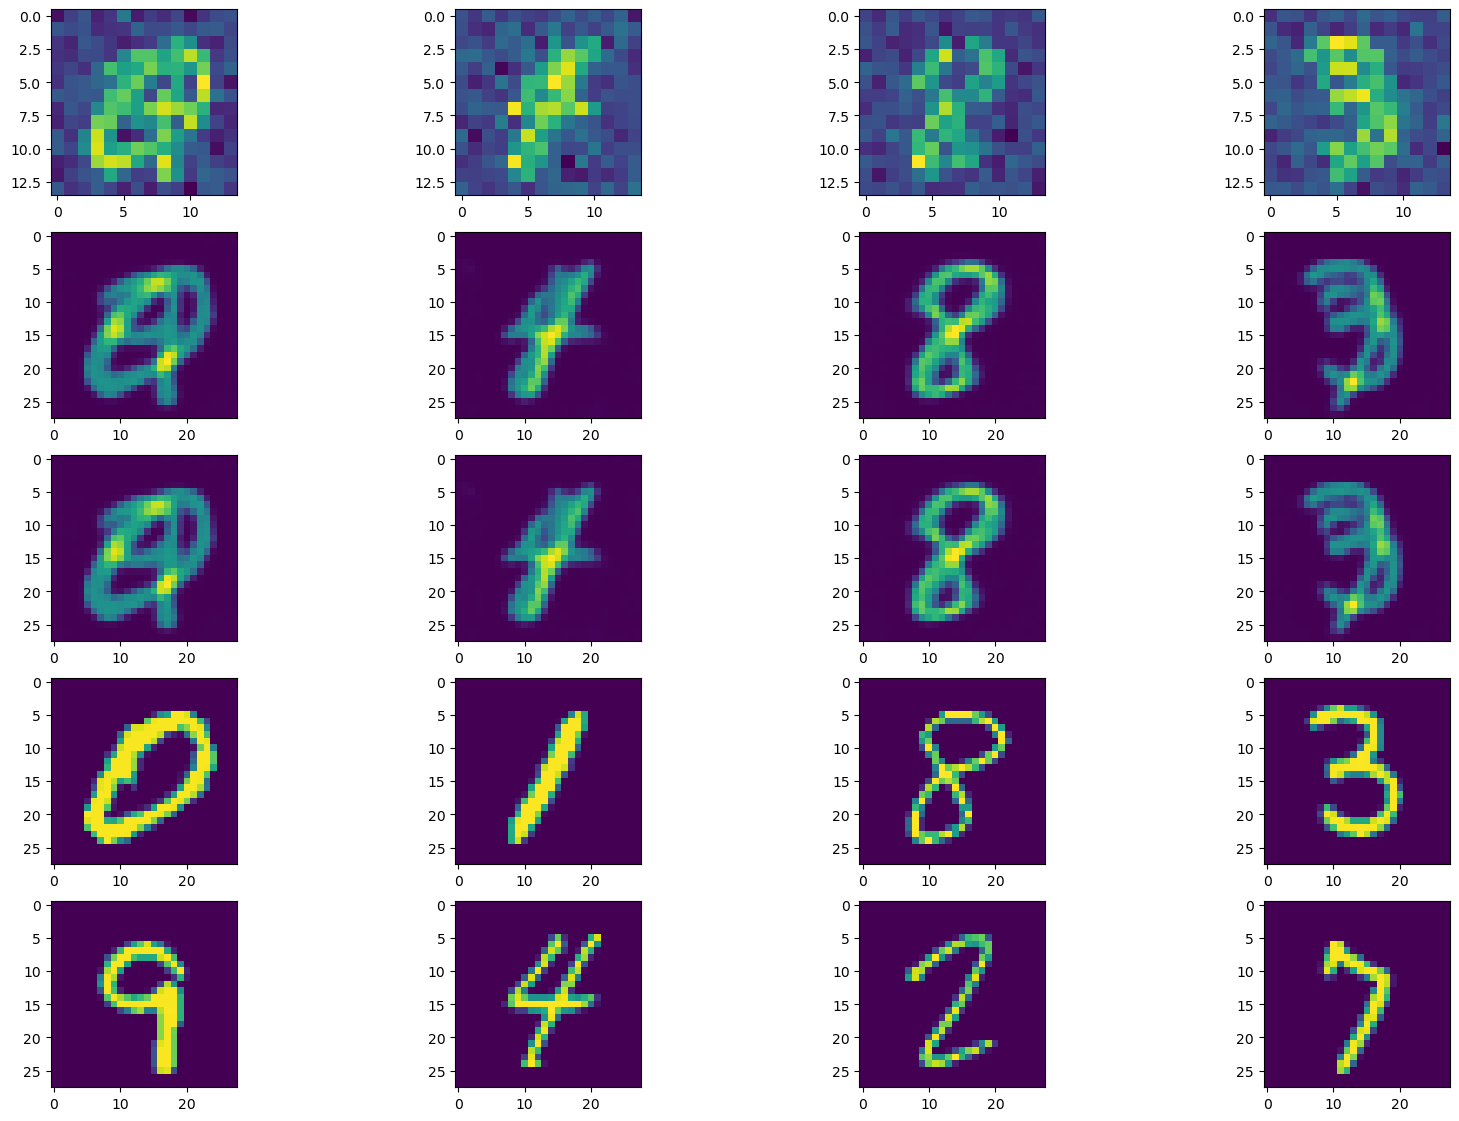

In [7]:
testset = DataLoader(test_supserimposed, batch_size=64, shuffle=True)
inputs,targets = next(iter(testset))
outputs = model(inputs.to(device))
show_outputs(outputs, targets, inputs)